# Appendix B: Implementation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Section 0: importing useful modules

In [1033]:
import hdf5storage
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from IPython.display import display, Math
from tqdm import tqdm
from scipy.stats import entropy
import pickle
from scipy.integrate import solve_ivp
from scipy.stats import norm as normal_distribution

# Section 1: model discovery for prey-predator data

## 1.1 Dataset

In [1119]:
data = zeros((30, 3))
data[:, 0] = range(1845, 1905, 2)
data[:, 1] = [20, 20, 52, 83, 64, 68,83,12,36,150,110,60,
              7,10,70,100,92,70,10,11,137,137,18,22,52,83,18,10,9,65]
data[:, 2] = [32, 50, 12, 10, 13, 36, 15, 12, 6,6,65,70,
              40,9,20,34,45,40,15,15,60,80,26,18,37,50,35,12,12,25]

In [1120]:
n = data.shape[0]-2
X = zeros((n, 2))
Y = zeros((n, 2))
Y[:, 0] = (data[2:, 1] - data[:n, 1])/(2*2)
Y[:, 1] = (data[2:, 2] - data[:n, 2])/(2*2)
X[:, 0] = data[1:-1, 1]
X[:, 1] = data[1:-1, 2]

## 1.2 Library of functions

In [1121]:
basis_elems = [
    #(array([1]*n), r"1", lambda x: 1),
    (X[:, 0], r"x_1", lambda x: x[0]),
    (X[:, 1], r"x_2", lambda x: x[1]),
    (X[:, 0]**2, r"x_1^2", lambda x: x[0]**2),
    (X[:, 1]**2, r"x_2^2", lambda x: x[1]**2), 
    (X[:, 0]*X[:, 1], r"x_1 x_2", lambda x: x[0]*x[1]),
    (X[:, 0]**3, r"x_1^3", lambda x: x[0]**3),
    (X[:, 1]**3, r"x_2^3", lambda x: x[1]**3),
    (X[:, 0]**2*X[:,1], r"x_1^2 x_2", lambda x: x[0]**2*x[1]),
    (X[:, 1]**2*X[:,0], "x_1 x_2^2", lambda x: x[0]*x[1]**2),
    (X[:, 0]**4, r"x_1^4", lambda x: x[0]**4),
    (X[:, 1]**4, r"x_2^4", lambda x: x[1]**4),
    (sin(X[:, 0]), r"\sin(x_1)", lambda x: sin(x[0])),
    (sin(X[:, 1]), r"\sin(x_2)", lambda x: sin(x[1])),
    (cos(X[:, 0]), r"\cos(x_1)", lambda x: cos(x[0])),
    (cos(X[:, 1]), r"\cos(x_2)", lambda x: cos(x[1])),
]
basis = dict(enumerate(basis_elems))
A = array([basis[i][0] for i in range(len(basis))]).T

## 1.3 Model fitting

In [1069]:
def get_function_from_coefs(coefs1, coefs2, teval=arange(0, 28, 1)):
    def f(t, u):
        up1 = 0
        up2 = 0
        for a, b, g in zip(coefs1, coefs2, basis_elems):
            up1 += a*g[2](u)
            up2 += b*g[2](u)
        return array([up1, up2])
    return solve_ivp(f, [0., 28], [20, 32], method='RK45', t_eval=teval)

In [1072]:
def kl_div(coefs1, coefs2, bins=10):
    opt = get_function_from_coefs(coefs1, coefs2)
    rrs_0 = (X[:, 0] - opt.y[0])**2
    rrs_0 = (rrs_0 - min(rrs_0))/std(rrs_0)
    hs_0 = histogram(rrs_0, bins=bins)
    rrs_1 = (X[:, 1] - opt.y[1])**2
    rrs_1 = (rrs_1 - min(rrs_1))/std(rrs_1)
    hs_1 = histogram(rrs_1, bins=bins)
    return entropy(hs_0[0]+0.1, normal_distribution.pdf(hs_0[1][1:])),
        entropy(hs_1[0]+0.1, normal_distribution.pdf(hs_1[1][1:]))

In [1122]:
import warnings
warnings.filterwarnings("ignore")

In [1124]:
lmbds = linspace(1, 30, 100)
bins=30

lynx_coefs = zeros((100, len(basis)))
aics = []
bics = []

lynx_coefs_2 = zeros((100, len(basis)))
aics_2 = []
bics_2 = []

for i, alpha in enumerate(lmbds):
    alg = ElasticNet(alpha, l1_ratio=0.01)
    #alg = Ridge(alpha)
    alg.fit(A, Y[:, 0])
    lynx_coefs[i, :] = alg.coef_
    k = sum(abs(alg.coef_) != 0)
    residual = 1/(2*n) * ((A.dot(alg.coef_) - Y[:, 0]) ** 2).sum()
    penalty = 0
    AIC = 2*k + n*log(residual+penalty)
    BIC = n*log((residual+penalty)/n) + k*log(n)
    AICc = AIC + (2*k**2 + 2*k)/(n-k-1)
    aics.append(AICc)
    bics.append(BIC)    

for i, alpha in enumerate(lmbds):
    alg = ElasticNet(alpha, l1_ratio=0.1)
    #alg = Ridge(alpha)
    alg.fit(A, Y[:, 1])
    lynx_coefs_2[i, :] = alg.coef_
    k = sum(alg.coef_ != 0)
    residual = 1/(2*n) * ((A.dot(alg.coef_) - Y[:, 1]) ** 2).sum()
    penalty = 0
    AIC = 2*k + n*log(residual+penalty)
    BIC = n*log((residual+penalty)/n) + k*log(n)
    AICc = AIC + (2*k**2 + 2*k)/(n-k-1)
    aics_2.append(AICc)
    bics_2.append(BIC)
    nonzero_coefs = alg.coef_[alg.coef_ != 0]
    
kl_1 = []
kl_2 = []
for i in range(len(lmbds)):
    a, b = kl_div(lynx_coefs[i, :], lynx_coefs_2[i, :])
    kl_1.append(a)
    kl_2.append(b)

## 1.4 Plotting results

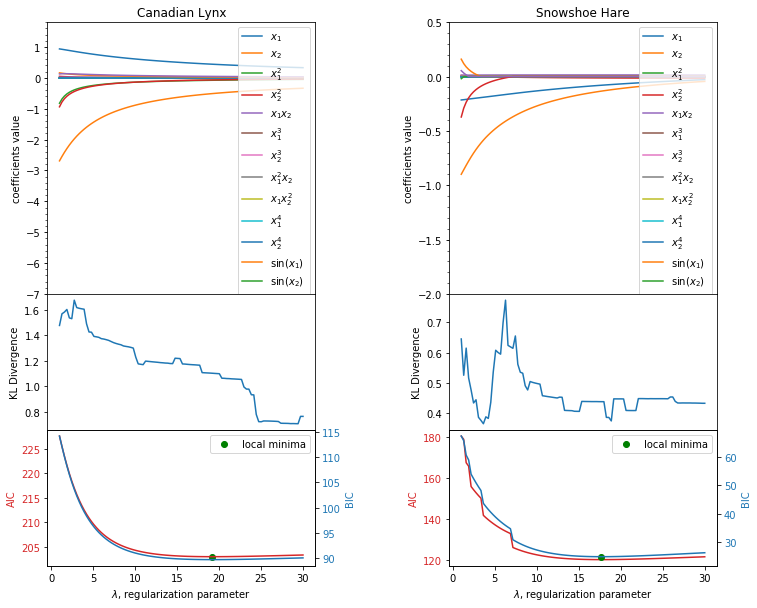

In [1109]:
fig = figure(figsize=(12, 10))
grid = plt.GridSpec(4, 2, wspace=0.5, hspace=0)
coefs_plot_1 = fig.add_subplot(grid[:2, 0])
coefs_plot_2 = fig.add_subplot(grid[:2, 1])
kl_plot_1 = fig.add_subplot(grid[2, 0])
kl_plot_2 = fig.add_subplot(grid[2, 1])
ic_plot_1 = fig.add_subplot(grid[3, 0])
ic_plot_2 = fig.add_subplot(grid[3, 1])

for i in range(len(basis)):
    coefs_plot_1.plot(lmbds, lynx_coefs[:, i], label="$"+basis_elems[i][1]+"$")
coefs_plot_1.legend()
coefs_plot_1.set_xticks([])
coefs_plot_1.set_yticks(arange(-7, 2, 1))
coefs_plot_1.set_yticks(arange(-7, 2, 0.2), minor=True)
coefs_plot_1.set_ylabel("coefficients value")

for i in range(len(basis)):
    coefs_plot_2.plot(lmbds, lynx_coefs_2[:, i], label="$"+basis_elems[i][1]+"$")
coefs_plot_2.legend()
coefs_plot_2.set_xticks([])
coefs_plot_2.set_yticks(arange(-2, 0.6, 0.5))
coefs_plot_2.set_yticks(arange(-2, 0.6, 0.1), minor=True)
coefs_plot_2.set_ylabel("coefficients value")

kl_plot_1.plot(kl_1)
kl_plot_1.set_xticks([])
#kl_plot_1.set_yticks(arange(2, 2.9, 0.2))
kl_plot_1.set_ylabel("KL Divergence")
kl_plot_2.plot(kl_2)
kl_plot_2.set_xticks([])
#kl_plot_2.set_yticks(arange(2, 2.9, 0.2))
kl_plot_2.set_ylabel("KL Divergence")


color = 'tab:red'
ic_plot_1.set_xlabel(r'$\lambda$, regularization parameter')
#ax1.set_xticks()
ic_plot_1.set_ylabel('AIC', color=color)
ic_plot_1.plot(lmbds, aics, color=color)
ic_plot_1.tick_params(axis='y', labelcolor=color)
ic_plot_12 = ic_plot_1.twinx()
color = 'tab:blue'
ic_plot_12.set_ylabel('BIC', color=color)  # we already handled the x-label with ax1
ic_plot_12.plot(lmbds, bics, color=color)
ic_plot_12.tick_params(axis='y', labelcolor=color)
#ic_plot_1.tight_layout() 
#opt = argmin(aics[:60])
opt1 = argmin(aics)
#ic_plot_1.scatter(lmbds[opt], aics[opt], c='g', marker='o', label='local minima')
ic_plot_1.scatter(lmbds[opt1], aics[opt1], c='g', marker='o', label="local minima")
ic_plot_1.legend()
ic_plot_1.set_xticks(arange(0, 31, 5))

color = 'tab:red'
ic_plot_2.set_xlabel(r'$\lambda$, regularization parameter')
#ax1.set_xticks()
ic_plot_2.set_ylabel('AIC', color=color)
ic_plot_2.plot(lmbds, aics_2, color=color)
ic_plot_2.tick_params(axis='y', labelcolor=color)
ic_plot_22 = ic_plot_2.twinx()
color = 'tab:blue'
ic_plot_22.set_ylabel('BIC', color=color)
ic_plot_22.plot(lmbds, bics_2, color=color)
ic_plot_22.tick_params(axis='y', labelcolor=color)
#ic_plot_1.tight_layout()
#opt2 = argmin(aics_2[:20])
opt3 = argmin(aics_2)
opt_coef2 = lynx_coefs_2[opt2]
opt_coef3 = lynx_coefs_2[opt3]
#ic_plot_2.scatter(lmbds[opt2], aics_2[opt2], c='g', label="local minima")
ic_plot_22.scatter(lmbds[opt3], bics_2[opt3], c='g', label="local minima")
ic_plot_22.legend()
ic_plot_2.set_xticks(arange(0, 31, 5))
coefs_plot_1.set_title("Canadian Lynx")
coefs_plot_2.set_title("Snowshoe Hare")
savefig(open("report/images/lynx_results.pdf", 'wb'), format="png")

## 1.5 Optimal models

<IPython.core.display.Math object>

<IPython.core.display.Math object>

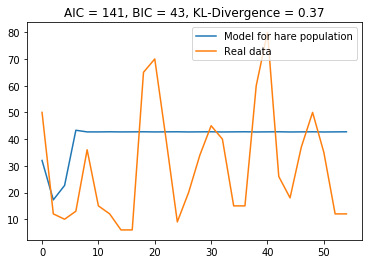

<IPython.core.display.Math object>

<IPython.core.display.Math object>

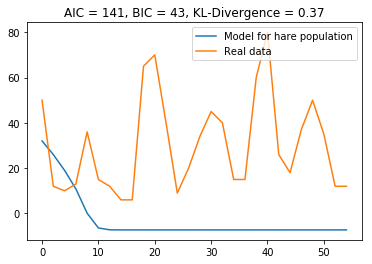

<IPython.core.display.Math object>

<IPython.core.display.Math object>

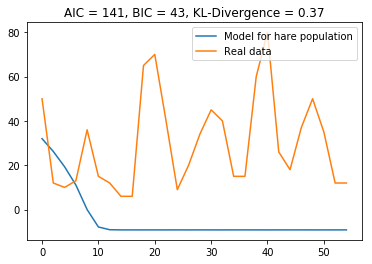

In [1118]:
def show_model(coefs, prefix=""):
    for i in arange(len(basis))[coefs != 0]:
        if abs(coefs[i]) > 5e-2*max(opt_coefs):
            prefix += "+" if coefs[i] > 0 else ""
            prefix += "%.4f"%(coefs[i]) + basis[i][1]
    #print(prefix)
    display(Math(prefix))
    

show_model(lynx_coefs[0], prefix=r"\dot{x} = ")
show_model(lynx_coefs_2[0], prefix=r"\dot{y} = ")
opt = get_function_from_coefs(lynx_coefs[0], lynx_coefs_2[0])
plot(opt.t*2, opt.y[1], label="Model for hare population")
plot(range(0, 56, 2), X[:, 1], label="Real data")
legend()
title("AIC = %d, BIC = %d, KL-Divergence = %.2g"%(aics_2[i], bics_2[i], kl_2[i]))
show()
print()
#show_model(lynx_coefs[opt2], prefix=r"\dot{x} = ")
#show_model(lynx_coefs_2[opt2], prefix=r"\dot{y} = ")
show_model(lynx_coefs[opt3], prefix=r"\dot{x} = ")
show_model(lynx_coefs_2[opt3], prefix=r"\dot{y} = ")
opt = get_function_from_coefs(lynx_coefs[opt3], lynx_coefs_2[opt3])
plot(opt.t*2, opt.y[1], label="Model for hare population")
plot(range(0, 56, 2), X[:, 1], label="Real data")
legend()
title("AIC = %d, BIC = %d, KL-Divergence = %.2g"%(aics_2[i], bics_2[i], kl_2[i]))
show()
print()
show_model(lynx_coefs[opt1], prefix=r"\dot{x} = ")
show_model(lynx_coefs_2[opt1], prefix=r"\dot{y} = ")
opt = get_function_from_coefs(lynx_coefs[opt1], lynx_coefs_2[opt1])
plot(opt.t*2, opt.y[1], label="Model for hare population")
plot(range(0, 56, 2), X[:, 1], label="Real data")
legend()
title("AIC = %d, BIC = %d, KL-Divergence = %.2g"%(aics_2[i], bics_2[i], kl_2[i]))
show()

## 1.6 Latent Variable Analysis

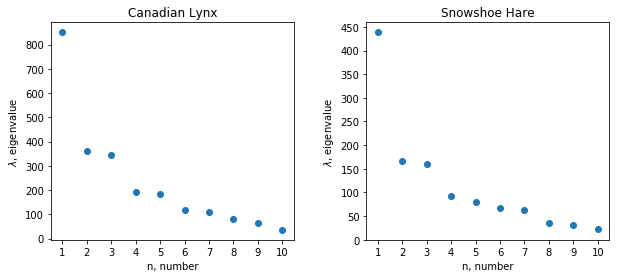

In [784]:
fig = figure(figsize=(10, 4))
grid = plt.GridSpec(1, 2, wspace=0.3, hspace=0)
eigen_plot_1 = fig.add_subplot(grid[0, 0])
eigen_plot_2 = fig.add_subplot(grid[0, 1])

c = X[:, 0]
shift = 10
TD = array([c[i:28-shift + i] for i in range(0, shift)])
U, S, V = svd(TD)

eigen_plot_1.scatter(arange(len(S))+1, S)
eigen_plot_1.set_xticks(arange(len(S))+1)
eigen_plot_1.set_xlabel("n, number")
eigen_plot_1.set_ylabel(r"$\lambda$, eigenvalue")
eigen_plot_1.set_title("Canadian Lynx")

c = X[:, 1]
shift = 10
TD = array([c[i:28-shift + i] for i in range(0, shift)])
U, S, V = svd(TD)

eigen_plot_2.scatter(arange(len(S))+1, S)
eigen_plot_2.set_xticks(arange(len(S))+1)
eigen_plot_2.set_yticks(arange(0, 500, 50))
eigen_plot_2.set_xlabel("n, number")
eigen_plot_2.set_ylabel(r"$\lambda$, eigenvalue")
eigen_plot_2.set_title("Snowshoe Hare")

savefig(open("report/images/lynx_eigenvalues.eps", 'wb'), format="eps")

# BZ.mat

## 1.1 Dataset

In [339]:
mat = hdf5storage.loadmat('BZ.mat')
mat['BZ_tensor'].shape

(351, 451, 1200)

In [1088]:
data = mat['BZ_tensor'][:, :, 180:240]

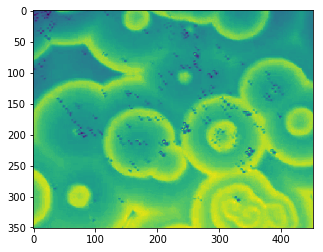

In [788]:
imshow(data[:, :, 10])

## 1.2 Library of functions 

In [1089]:
dt = 1
dx = 1
dy = 1
m, n, k = data.shape
#data = (data - mean(data))
#data /= data.max()
Y = (data[1:-1, 1:-1, 2:] - data[1:-1, 1:-1, :-2])/(2*dt)
dUx = (data[2:, 1:-1, 1:-1] - data[:-2, 1:-1, 1:-1])/(2*dx)
dUy = (data[1:-1, 2:, 1:-1] - data[1:-1, :-2, 1:-1])/(2*dy)
dUx2 = (data[2:, 1:-1, 1:-1] - 2*data[1:-1, 1:-1, 1:-1] + data[:-2, 1:-1, 1:-1])/(dx**2)
dUy2 = (data[2:, 1:-1, 1:-1] - 2*data[1:-1, 1:-1, 1:-1] + data[:-2, 1:-1, 1:-1])/(dx**2)
dUxy = (data[2:, 2:, 1:-1] - data[2:, :-2, 1:-1] - data[:-2, 2:, 1:-1] + data[:-2, :-2, 1:-1])/(4*dx*dy)
Y = Y.reshape(((m-2)*(n-2)*(k-2)))
U = data[1:-1, 1:-1, 1:-1]
U = U.reshape(((m-2)*(n-2)*(k-2)))
dUx = dUx.reshape(((m-2)*(n-2)*(k-2)))
dUy = dUy.reshape(((m-2)*(n-2)*(k-2)))
dUx2 = dUx2.reshape(((m-2)*(n-2)*(k-2)))
dUy2 = dUy2.reshape(((m-2)*(n-2)*(k-2)))
dUxy = dUxy.reshape(((m-2)*(n-2)*(k-2)))
m, n, k = m-2, n-2, k-2

In [1113]:
basis_elems = [
    (U, r"U"),
    #(sin(U), r"\sin(U)"),
    #(cos(U), r"\cos(U)"),
    #(U**2, r"U^2"),
    (dUx, r"U_x"),
    (dUy, r"U_y"),
    #(dUx + dUy, r"(U_x + U_y)"),
    #(dUx - dUy, r"(U_x - U_y)"),
    (dUx*dUx, r"U_{xx}"),
    (dUx*dUy, r"U_{yy}"),
    #(dUx*dUy, r"U_xU_y"),
    #(U*dUx2, r"U*U_{xx}"),
    #(U*dUy2, r"U*U_{yy}"),
    (dUxy, r"U_{xy}")
]
basis = dict(enumerate(basis_elems))
A = array([basis[i][0] for i in range(len(basis))]).T

## 1.3 Model fitting 

<IPython.core.display.Math object>

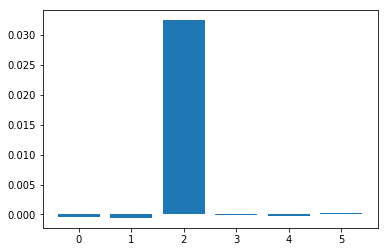

In [1094]:
alg = Lasso(alpha=1e-5)
alg.fit(A, Y)
coefs = alg.coef_
k = len(coefs)
bar(range(len(coefs)), coefs)
model_str = r"U_t = "
for i in arange(len(basis))[coefs != 0]:
    model_str += "+" if coefs[i] > 0 else ""
    model_str += "%.2g"%(coefs[i]) + basis[i][1]
display(Math(model_str))

In [404]:
coefs_list = []
for i in tqdm(range(0, 1000, 100)):
    data = mat['BZ_tensor'][:, :, i:i+300]
    dt = 1
    dx = 1
    dy = 1
    m, n, k = data.shape
    #data = (data - mean(data))
    #data /= data.max()
    Y = (data[1:-1, 1:-1, 2:] - data[1:-1, 1:-1, :-2])/(2*dt)
    dUx = (data[2:, 1:-1, 1:-1] - data[:-2, 1:-1, 1:-1])/(2*dx)
    dUy = (data[1:-1, 2:, 1:-1] - data[1:-1, :-2, 1:-1])/(2*dy)
    dUx2 = (data[2:, 1:-1, 1:-1] - 2*data[1:-1, 1:-1, 1:-1] + data[:-2, 1:-1, 1:-1])/(dx**2)
    dUy2 = (data[2:, 1:-1, 1:-1] - 2*data[1:-1, 1:-1, 1:-1] + data[:-2, 1:-1, 1:-1])/(dx**2)
    dUxy = (data[2:, 2:, 1:-1] - data[2:, :-2, 1:-1] - data[:-2, 2:, 1:-1] + data[:-2, :-2, 1:-1])/(4*dx*dy)
    Y = Y.reshape(((m-2)*(n-2)*(k-2)))
    U = data[1:-1, 1:-1, 1:-1]
    U = U.reshape(((m-2)*(n-2)*(k-2)))
    dUx = dUx.reshape(((m-2)*(n-2)*(k-2)))
    dUy = dUy.reshape(((m-2)*(n-2)*(k-2)))
    dUx2 = dUx2.reshape(((m-2)*(n-2)*(k-2)))
    dUy2 = dUy2.reshape(((m-2)*(n-2)*(k-2)))
    dUxy = dUxy.reshape(((m-2)*(n-2)*(k-2)))
    m, n, k = m-2, n-2, k-2
    basis_elems = [
        (U, r"U"),
        #(sin(U), r"\sin(U)"),
        #(cos(U), r"\cos(U)"),
        #(U**2, r"U^2"),
        (dUx, r"U_x"),
        (dUy, r"U_y"),
        #(U*dUx, r"UU_x"),
        #(U*dUy, r"UU_y"),
        #(dUx*dUy, r"U_xU_y"),
        (dUx2, r"U_{xx}"),
        (dUy2, r"U_{yy}"),
        (dUxy, r"U_{xy}")
    ]
    basis = dict(enumerate(basis_elems))
    A = array([basis[i][0] for i in range(len(basis))]).T
    alg = Lasso(alpha=1e-5)
    alg.fit(A, Y)
    coefs_list.append(alg.coef_)


100%|██████████| 10/10 [14:34<00:00, 87.43s/it]


## 1.4 Plotting results

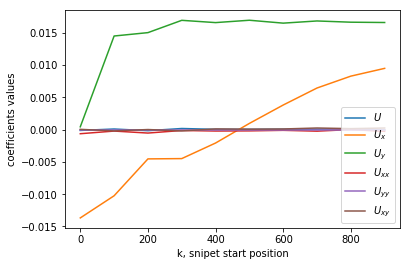

In [1114]:
coefs = zeros((len(basis), 10))
kls = zeros(10)
for i, c in enumerate(coefs_list):
    coefs[:, i] = c
    hs = histogram(coefs, bins=bins)
    kls[i] = entropy(hs[0], [1]*len(hs[0]))

fig, ax1 = plt.subplots()
for j in range(len(basis)):
    ax1.plot(range(0, 1000, 100), coefs[j, :], label="$"+basis_elems[j][1]+"$")
#ax2 = ax1.twinx()
#ax2.plot(range(0, 1000, 100), kls, '--', label="KL-divergence", c='b')
#ax2.tick_params(axis='y', labelcolor='b')
ax1.legend()
ax2.legend()
ax1.set_xlabel("k, snipet start position")
ax1.set_ylabel("coefficients values")
#ax2.set_ylabel("KL-Divergence")
savefig(open("report/images/video_coefs.pdf", 'wb'), format="pdf")
show()